# IJEPA Pretrained Model Evaluation and MLP Decoder Training
This notebook demonstrates how to:
- Load a pretrained IJEPA checkpoint and evaluate it on a test set (average test loss).
- Prepare and train an MLP decoder for classification using labels from `.xlsx` files.
- Keep each major step in a separate cell for clarity and reproducibility.

**Update the file paths as needed for your setup.**

In [1]:
# Cell 1: Imports and Setup
import os
import yaml
import torch
torch.set_num_threads(16)
print(f"Number of threads: {torch.get_num_threads()}")
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd

# add the path to the src directory
import sys
# Use a raw string to avoid unicode escape issues on Windows
sys.path.append(r"C:\Users\dash\Documents\Wosler\learning_ai\ijepa")
from src.helper import init_model

Number of threads: 16


## Load Config, and Checkpoint
- Loads the experiment config and pretrained checkpoint.
- Initializes the encoder and predictor.

In [2]:
# Cell 2: Load config and checkpoint, prepare test set
# --- Set your paths here ---
config_path = r'..\configs\simUS_dataset_new_vit_small_16_ep100.yaml'
checkpoint_path = r'..\exp_logs\vit_small_spherical_ep100\vit_small_spherical_ep100-ep100.pth.tar'

# Load config
def load_yaml_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

cfg = load_yaml_config(config_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Init model and predictor
encoder, predictor = init_model(
    device=device,
    patch_size=cfg["mask"]["patch_size"],
    crop_size=cfg["data"]["crop_size"],
    pred_depth=cfg["meta"]["pred_depth"],
    pred_emb_dim=cfg["meta"]["pred_emb_dim"],
    model_name=cfg["meta"]["model_name"]
)
encoder.eval()
predictor.eval()

# Remove 'module.' prefix if present in checkpoint keys
def remove_module_prefix(state_dict):
    return {k.replace('module.', ''): v for k, v in state_dict.items()}

# Load checkpoint
ckpt = torch.load(checkpoint_path, map_location=device)
encoder.load_state_dict(remove_module_prefix(ckpt["encoder"]), strict=False)
predictor.load_state_dict(remove_module_prefix(ckpt["predictor"]), strict=False)


INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
)


<All keys matched successfully>

# Preparing context and target patches from images

In [3]:
# Cell 3: Visualize context (top half) and target (bottom half) patches on an image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Set your image path here ---
image_path = r'C:\Users\dash\Documents\Wosler\learning_ai\ijepa\dataset\dataset_DATE_2025_06_19_TIME_14_45_15\train\class0\23.png'

# Add project root to path if needed
sys.path.append(r"..")
from src.masks.multiblock import MaskCollator

# --- Set patch size and crop size ---
patch_size = cfg['mask']['patch_size']
crop_size = cfg['data']['crop_size']

from src.transforms import make_transforms

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((cfg['data']['crop_size'], cfg['data']['crop_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)
print(f"Input tensor shape: {input_tensor.shape}")

# Prepare context and target indices (all patches)
num_patches = (crop_size // patch_size) ** 2
context_indices = torch.arange(num_patches, device=device).unsqueeze(0)  # [1, 196]
target_indices = torch.arange(num_patches, device=device).unsqueeze(0)   # [1, 196]


Input tensor shape: torch.Size([1, 3, 224, 224])


# Visualize context and target patches 

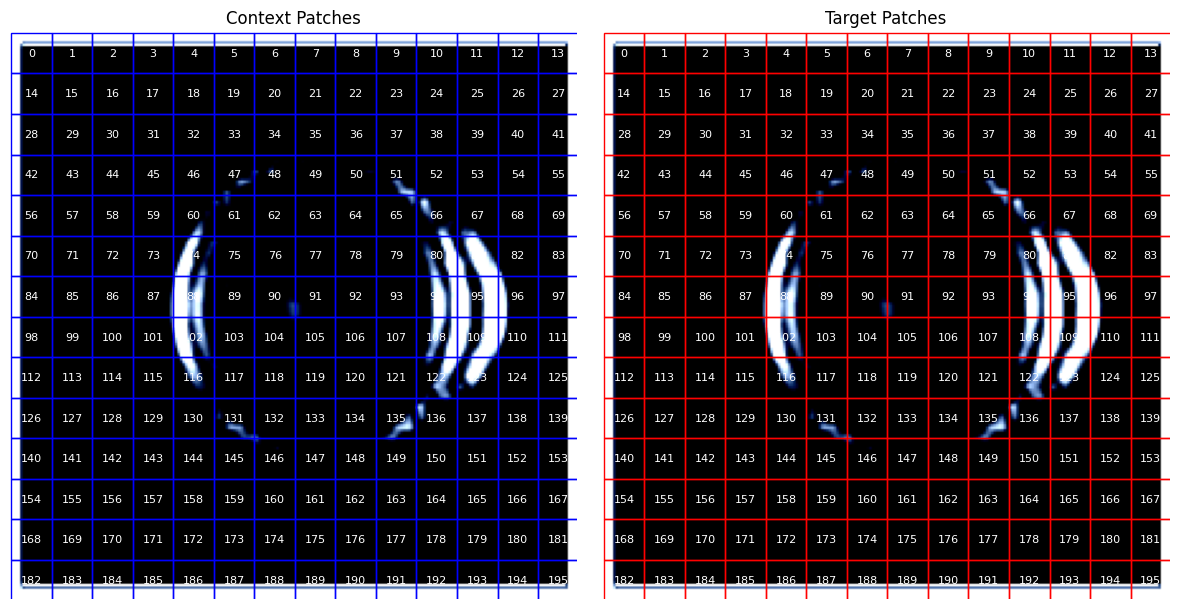

In [4]:
# Cell 4: Define the visualization function

# ---- Visualize patches on input_tensor on two different figures ----
def visualize_patches(input_tensor, context_indices, target_indices, patch_size):
    # Convert indices to 1D numpy arrays for iteration
    context_indices_np = context_indices.squeeze().cpu().numpy()
    target_indices_np = target_indices.squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # on the left plot, show the context patches
    axs[0].imshow(input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Context Patches")
    axs[0].axis('off')
    for idx in context_indices_np:
        row = idx // (input_tensor.shape[2] // patch_size)
        col = idx % (input_tensor.shape[2] // patch_size)
        rect = patches.Rectangle((col * patch_size, row * patch_size), patch_size, patch_size,
                                 linewidth=1, edgecolor='b', facecolor='none')
        axs[0].text(col * patch_size + patch_size / 2, row * patch_size + patch_size / 2,
                    str(idx), color='white', fontsize=8, ha='center', va='center')
        axs[0].add_patch(rect)

    # on the right plot, show the target patches
    axs[1].imshow(input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[1].set_title("Target Patches")
    axs[1].axis('off')
    for idx in target_indices_np:
        row = idx // (input_tensor.shape[2] // patch_size)
        col = idx % (input_tensor.shape[2] // patch_size)
        rect = patches.Rectangle((col * patch_size, row * patch_size), patch_size, patch_size,
                                 linewidth=1, edgecolor='r', facecolor='none')
        axs[1].text(col * patch_size + patch_size / 2, row * patch_size + patch_size / 2,
                    str(idx), color='white', fontsize=8, ha='center', va='center')
        axs[1].add_patch(rect)

    plt.tight_layout()
    plt.show()

# Usage:
visualize_patches(input_tensor, context_indices, target_indices, patch_size)

## Pass each patch through the encoder and predictor and compare


torch.Size([1, 196, 384])
torch.Size([1, 196, 384])


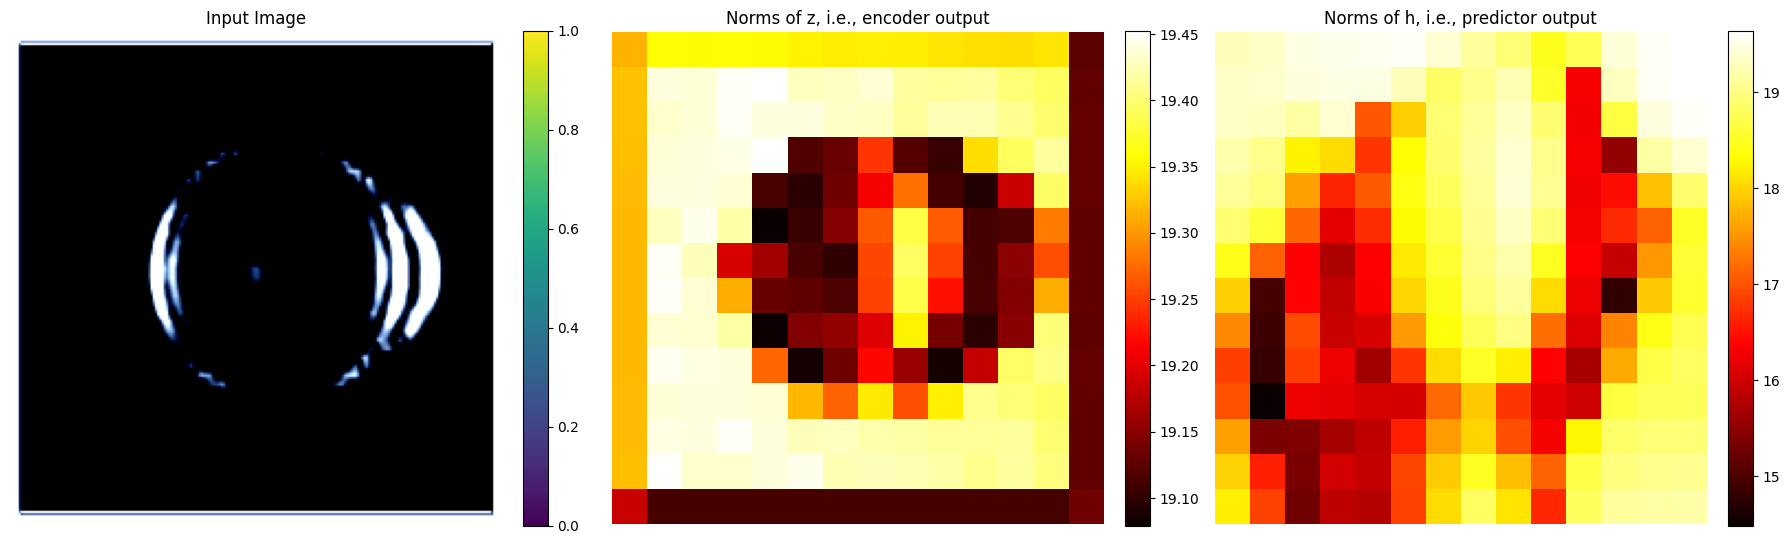

In [5]:
# Cell 5: Get encoder and predictor outputs, visualize norms as heatmaps

# Get encoder and predictor outputs for all patches
with torch.no_grad():
    z = encoder(input_tensor, context_indices)  # [1, 196, emb_dim]
    h = predictor(z, context_indices, target_indices)  # [1, 196, emb_dim]

print(z.shape)  # [1, 196, emb_dim]
print(h.shape)  # [1, 196, emb_dim]

def display_norms_as_heatmap(z, h):
    z_norms = torch.norm(z, dim=-1).squeeze().cpu().numpy()  # [196]
    h_norms = torch.norm(h, dim=-1).squeeze().cpu().numpy()  # [196]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    im0 = axs[0].imshow(input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(z_norms.reshape(14, 14), cmap='hot', interpolation='nearest')
    axs[1].set_title('Norms of z, i.e., encoder output')
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(h_norms.reshape(14, 14), cmap='hot', interpolation='nearest')
    axs[2].set_title('Norms of h, i.e., predictor output')
    axs[2].axis('off')
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Usage:
display_norms_as_heatmap(z, h)

# Prepare input tensors for all images in train/val/test sets

In [15]:
# Cell 6: Prepare the images from the datasets

train_dir = r'..\dataset\dataset_DATE_2025_06_19_TIME_14_45_15\train\class0'
val_dir = r'..\dataset\dataset_DATE_2025_06_19_TIME_14_45_15\val\class0'
test_dir = r'..\dataset\dataset_DATE_2025_06_19_TIME_14_45_15\test\class0'

import glob

train_images = glob.glob(os.path.join(train_dir, '*.png'))
val_images = glob.glob(os.path.join(val_dir, '*.png'))
test_images = glob.glob(os.path.join(test_dir, '*.png'))

# load all images for each into a tensor
def load_images(image_paths, transform):
    # List comprehension for fast loading and transformation
    images = [transform(Image.open(p).convert("RGB")) for p in image_paths]
    # Stack into a single tensor of shape [N, C, H, W]
    return torch.stack(images, dim=0)

# load the images
train_images_tensor = load_images(train_images, transform).to(device)
val_images_tensor = load_images(val_images, transform).to(device)
test_images_tensor = load_images(test_images, transform).to(device)

# Print shapes to verify
print(f"Train images tensor shape: {train_images_tensor.shape}")  # [N, C, H, W]
print(f"Val images tensor shape: {val_images_tensor.shape}")      # [N, C, H, W]
print(f"Test images tensor shape: {test_images_tensor.shape}")    # [N, C, H, W]


Train images tensor shape: torch.Size([1006, 3, 224, 224])
Val images tensor shape: torch.Size([215, 3, 224, 224])
Test images tensor shape: torch.Size([70, 3, 224, 224])


# Pass these images through the encoder and predictor

In [16]:
# Cell 7: Get the lateral embeddings for all images in the datasets

# Repeat context and target indices for each image in the batch
train_context_indices = torch.arange(num_patches, device=device).unsqueeze(0).repeat(train_images_tensor.shape[0], 1)  # [N, 196]
train_target_indices = torch.arange(num_patches, device=device).unsqueeze(0).repeat(train_images_tensor.shape[0], 1)   # [N, 196]
val_context_indices = torch.arange(num_patches, device=device).unsqueeze(0).repeat(val_images_tensor.shape[0], 1)  # [N, 196]
val_target_indices = torch.arange(num_patches, device=device).unsqueeze(0).repeat(val_images_tensor.shape[0], 1)   # [N, 196]
test_context_indices = torch.arange(num_patches, device=device).unsqueeze(0).repeat(test_images_tensor.shape[0], 1)  # [N, 196]
test_target_indices = torch.arange(num_patches, device=device).unsqueeze(0).repeat(test_images_tensor.shape[0], 1)   # [N, 196]

# Define a function to get lateral embeddings for all images
def get_lateral_embeddings(images_tensor, context_indices, target_indices):
    with torch.no_grad():
        # Get the lateral embeddings for all images
        z = encoder(images_tensor, context_indices) # [N, 196, emb_dim]
        h = predictor(z, context_indices, target_indices) # [N, 196, emb_dim]
    return z, h

# Get lateral embeddings for train, val, and test sets
train_lateral_embeddings, train_predictor_embeddings = get_lateral_embeddings(train_images_tensor, train_context_indices, train_target_indices)
val_lateral_embeddings, val_predictor_embeddings = get_lateral_embeddings(val_images_tensor, val_context_indices, val_target_indices)
test_lateral_embeddings, test_predictor_embeddings = get_lateral_embeddings(test_images_tensor, test_context_indices, test_target_indices)

# Print shapes to verify
print(f"Train lateral embeddings shape: {train_lateral_embeddings.shape}")  # [N, 196, emb_dim]
print(f"Train predictor embeddings shape: {train_predictor_embeddings.shape}")  # [N, 196, emb_dim]
print(f"Val lateral embeddings shape: {val_lateral_embeddings.shape}")  # [N, 196, emb_dim]
print(f"Val predictor embeddings shape: {val_predictor_embeddings.shape}")  # [N, 196, emb_dim]
print(f"Test lateral embeddings shape: {test_lateral_embeddings.shape}")  # [N, 196, emb_dim]
print(f"Test predictor embeddings shape: {test_predictor_embeddings.shape}")  # [N, 196, emb_dim]

Train lateral embeddings shape: torch.Size([1006, 196, 384])
Train predictor embeddings shape: torch.Size([1006, 196, 384])
Val lateral embeddings shape: torch.Size([215, 196, 384])
Val predictor embeddings shape: torch.Size([215, 196, 384])
Test lateral embeddings shape: torch.Size([70, 196, 384])
Test predictor embeddings shape: torch.Size([70, 196, 384])


# Plot heatmaps for one image from each set

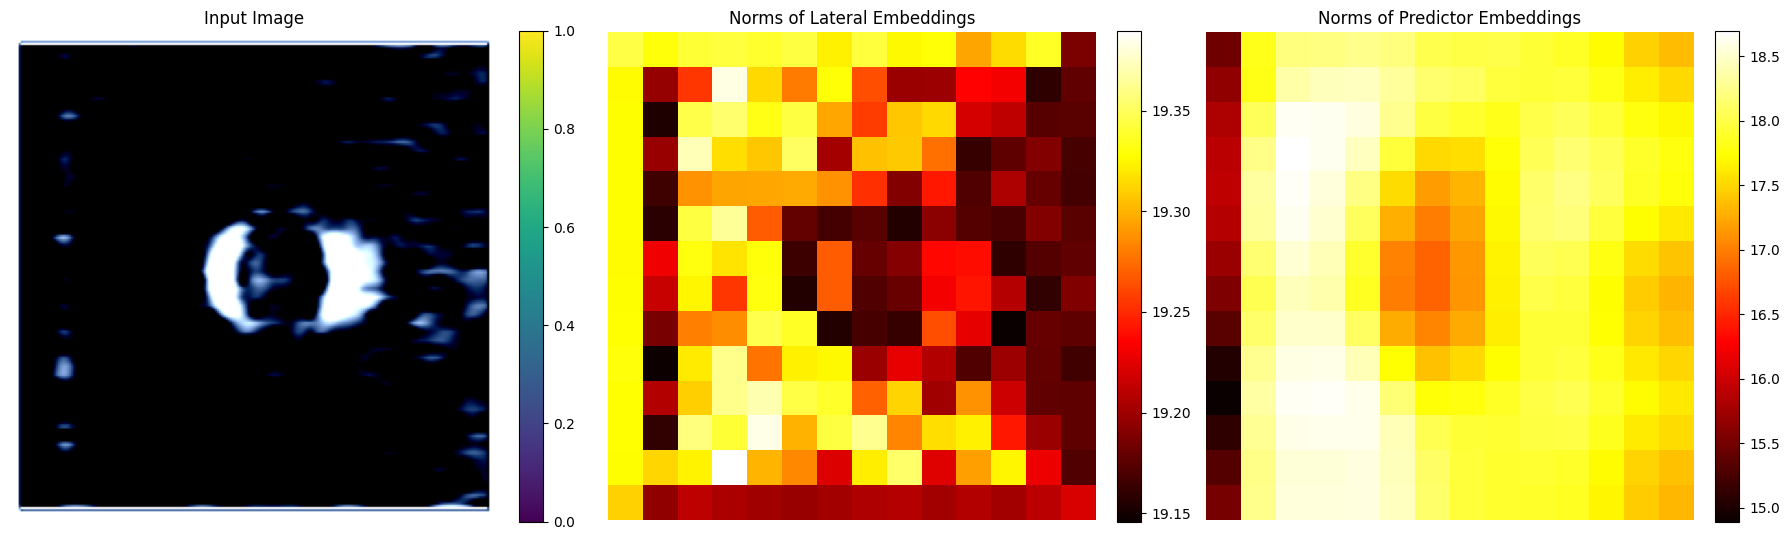

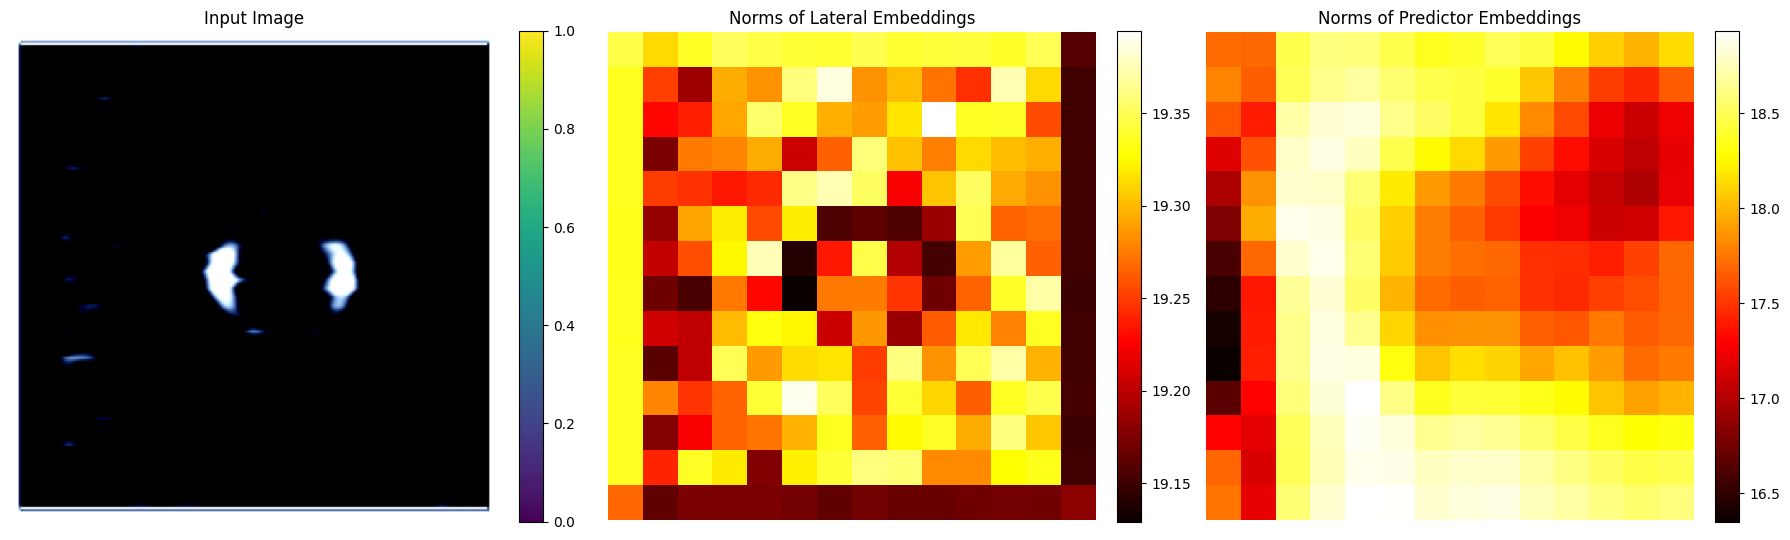

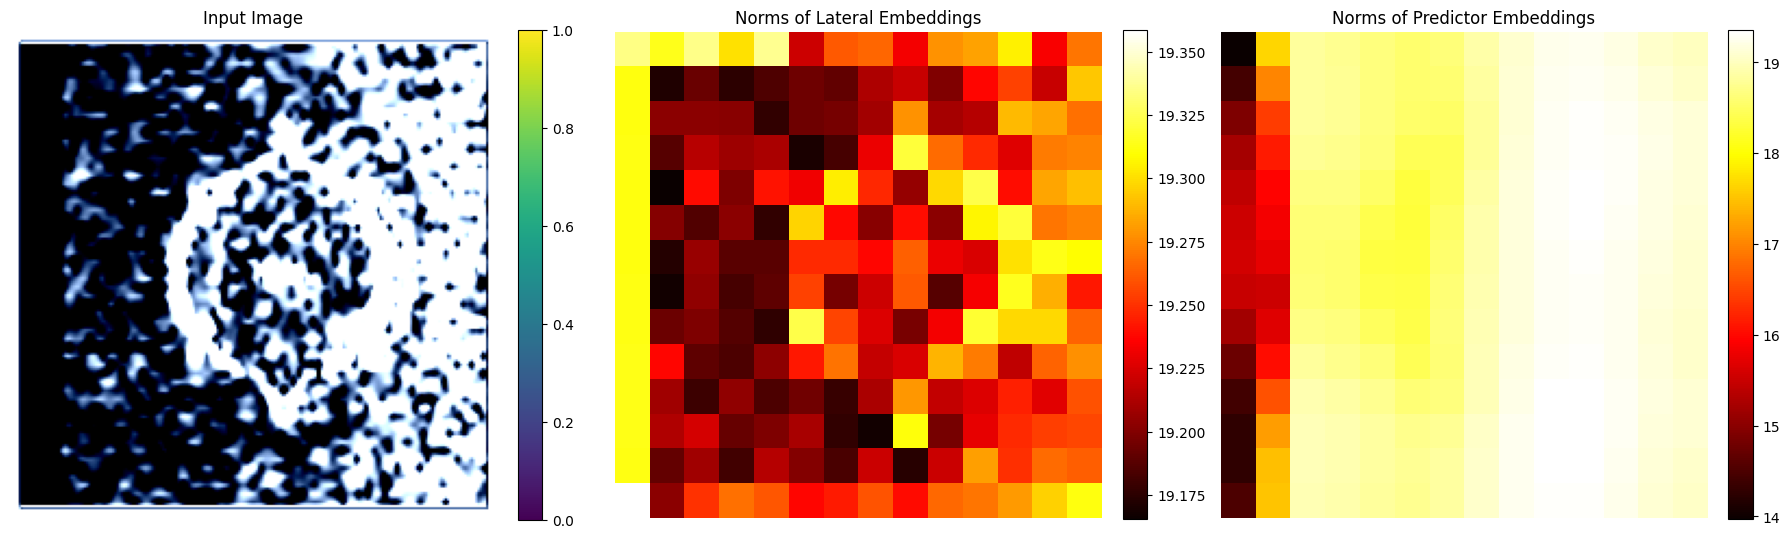

In [17]:
# Cell 8: Plot heatmaps for one each from train, val, and test sets

# Function to plot heatmaps for lateral and predictor embeddings
def plot_heatmaps(lateral_embeddings, predictor_embeddings, image_tensor, patch_size):
    lateral_norms = torch.norm(lateral_embeddings, dim=-1).squeeze().cpu().numpy()  # [196]
    predictor_norms = torch.norm(predictor_embeddings, dim=-1).squeeze().cpu().numpy()  # [196]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    im0 = axs[0].imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(lateral_norms.reshape(14, 14), cmap='hot', interpolation='nearest')
    axs[1].set_title('Norms of Lateral Embeddings')
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(predictor_norms.reshape(14, 14), cmap='hot', interpolation='nearest')
    axs[2].set_title('Norms of Predictor Embeddings')
    axs[2].axis('off')
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

train_index = train_images_tensor.shape[0] // 10  # Middle index for train set
val_index = val_images_tensor.shape[0] // 3  # Middle index for val set
test_index = test_images_tensor.shape[0] // 2   # Middle index for test set

# Plot heatmaps for one image from each set
plot_heatmaps(
    train_lateral_embeddings[train_index:train_index+1],
    train_predictor_embeddings[train_index:train_index+1],
    train_images_tensor[train_index:train_index+1],
    patch_size
)
plot_heatmaps(
    val_lateral_embeddings[val_index:val_index+1],
    val_predictor_embeddings[val_index:val_index+1],
    val_images_tensor[val_index:val_index+1],
    patch_size
)
plot_heatmaps(
    test_lateral_embeddings[test_index:test_index+1],
    test_predictor_embeddings[test_index:test_index+1],
    test_images_tensor[test_index:test_index+1],
    patch_size
)


# Load the labels for the binary classification task for the train/val/test sets

In [18]:
# Cell 9: Load the labels and convert them to tensors

# first load the .xlsx file containing the class labels for all images in the train, val, and test sets
xlsx_path = r'..\dataset\dataset_DATE_2025_06_19_TIME_14_45_15\train\class0\original_class_info.xlsx'

# load the xlsx file
def load_class_info(xlsx_path):
    df = pd.read_excel(xlsx_path)
    return df

class_info_df = load_class_info(xlsx_path)

# The label relevant to this classification task is stored under 'material_fill' label
# The name of an image in either train_images, val_images, or test_images is stored under 'image' label
# get the labels for train, val, and test sets
def get_labels(class_info_df, image_paths):
    # Extract the image names from the paths
    image_names = [os.path.basename(p) for p in image_paths]
    # Map the labels to the image names
    labels = class_info_df.set_index('image')['material_fill'].reindex(image_names).values
    # if the 'material_fill' is 'solid', set the label to 1, otherwise set it to 0
    labels = np.where(labels == 'solid', 1, 0)
    # Convert to torch tensor   
    labels = torch.tensor(labels, dtype=torch.float32).to(device)
    return labels

train_labels = get_labels(class_info_df, train_images)
val_labels = get_labels(class_info_df, val_images)
test_labels = get_labels(class_info_df, test_images)
# Print shapes to verify
print(f"Train labels shape: {train_labels.shape}")  # [N]
print(f"Val labels shape: {val_labels.shape}")      # [N]
print(f"Test labels shape: {test_labels.shape}")    # [N]

Train labels shape: torch.Size([1006])
Val labels shape: torch.Size([215])
Test labels shape: torch.Size([70])


# Use the lateral embeddings, train an MLP decoder to perform a binary classification task

MLPClassifier(
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)
Train lateral embeddings shape for classifier: torch.Size([1006, 384])
Val lateral embeddings shape for classifier: torch.Size([215, 384])
Train labels shape for classifier: torch.Size([1006])
Val labels shape for classifier: torch.Size([215])
Epoch [1/100], Loss: 0.6857, Val Loss: 0.6458
Epoch [2/100], Loss: 0.6168, Val Loss: 0.6313
Epoch [3/100], Loss: 0.5930, Val Loss: 0.5972
Epoch [4/100], Loss: 0.5636, Val Loss: 0.5585
Epoch [5/100], Loss: 0.5338, Val Loss: 0.5271
Epoch [6/100], Loss: 0.5080, Val Loss: 0.5027
Epoch [7/100], Loss: 0.4868, Val Loss: 0.4823
Epoch [8/100], Loss: 0.4668, Val Loss: 0.4647
Epoch [9/100], Loss: 0.4469, Val Loss: 0.4483
Epoch [10/100], Loss: 0.4270, Val Loss: 0.4314
Epoch [11/100], Loss: 0.4066, Val Loss: 0.4115
Epoch [12/100], Loss: 0.3846, Val Loss: 0.3888


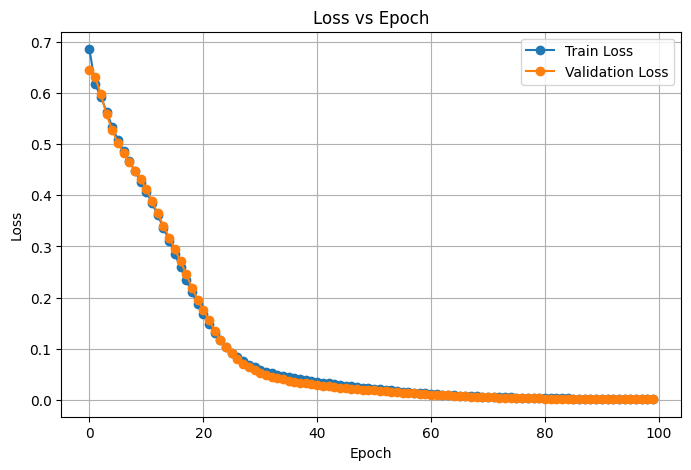

Test lateral embeddings shape for classifier: torch.Size([70, 384])
Test labels shape for classifier: torch.Size([70])
Test Loss: 0.0480, Test Accuracy: 0.9571


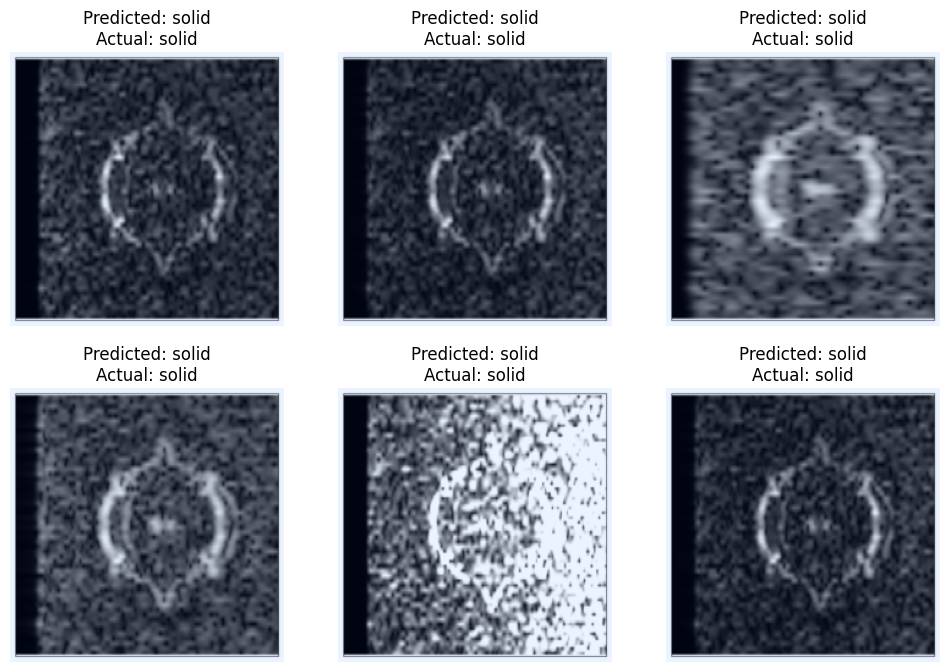

In [73]:
# Cell 10: Define an MLP classifier for the embeddings with two hidden layers
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Use sigmoid for binary classification
        return x
    
# Initialize the classifier and define loss and optimizer
# Initialize the classifier
input_dim = train_lateral_embeddings.shape[-1]  # emb_dim
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = 1  # Binary classification (solid vs hollow)
classifier = MLPClassifier(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)
# Ensure the classifier is on the same device as the embeddings
classifier.to(device)
# Print the classifier architecture
print(classifier)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

def train_classifier(classifier, train_embeddings, train_labels, val_embeddings, val_labels, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        classifier.train()
        optimizer.zero_grad()
        outputs = classifier(train_embeddings)
        loss = criterion(outputs.squeeze(), train_labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        classifier.eval()
        with torch.no_grad():
            val_outputs = classifier(val_embeddings)
            val_loss = criterion(val_outputs.squeeze(), val_labels)
            val_losses.append(val_loss.item())
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    return train_losses, val_losses

# Each patch has an embedding of size emb_dim, so we need to average the embeddings across all patches for each image
avg_train_lateral_embeddings = train_lateral_embeddings.mean(dim=1)  # [N, emb_dim]
avg_val_lateral_embeddings = val_lateral_embeddings.mean(dim=1)  # [N, emb_dim]
# Convert to float32 for compatibility with the classifier
avg_train_lateral_embeddings = avg_train_lateral_embeddings.float()
avg_val_lateral_embeddings = avg_val_lateral_embeddings.float()
# Print shapes to verify
print(f"Train lateral embeddings shape for classifier: {avg_train_lateral_embeddings.shape}")  # [N, emb_dim]
print(f"Val lateral embeddings shape for classifier: {avg_val_lateral_embeddings.shape}")      # [N, emb_dim]
# Convert labels to float32 for compatibility with the classifier
train_labels = train_labels.float()
val_labels = val_labels.float()
# Print shapes to verify
print(f"Train labels shape for classifier: {train_labels.shape}")  # [N]
print(f"Val labels shape for classifier: {val_labels.shape}")      # [N]

# Train the classifier on the train set and validate on the val set
train_losses, val_losses = train_classifier(
    classifier,
    avg_train_lateral_embeddings.to(device),
    train_labels.to(device),
    avg_val_lateral_embeddings.to(device),
    val_labels.to(device),
    criterion,
    optimizer,
    num_epochs=100
)

# Plot loss vs epoch
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, 'o-', label='Train Loss')
plt.plot(val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Test the MLP decoder on the test set and evaluate its performance
def evaluate_classifier(classifier, test_embeddings, test_labels, criterion):
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(test_embeddings)
        loss = criterion(outputs.squeeze(), test_labels)
        predictions = (outputs.squeeze() > 0.5).float()  # Threshold at 0.5 for binary classification
        accuracy = (predictions == test_labels).float().mean().item()
    return loss.item(), accuracy

# Average the embeddings across all patches for each image in the test set
avg_test_lateral_embeddings = test_lateral_embeddings.mean(dim=1)  # [N, emb_dim]
# Convert to float32 for compatibility with the classifier
avg_test_lateral_embeddings = avg_test_lateral_embeddings.float()
# Print shape to verify
print(f"Test lateral embeddings shape for classifier: {avg_test_lateral_embeddings.shape}")  # [N, emb_dim]
# Convert labels to float32 for compatibility with the classifier
test_labels = test_labels.float()
# Print shape to verify
print(f"Test labels shape for classifier: {test_labels.shape}")  # [N]

# Evaluate the classifier on the test set
test_loss, test_accuracy = evaluate_classifier(
    classifier,
    avg_test_lateral_embeddings.to(device),
    test_labels.to(device),
    criterion
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Test the classifier on 6 random images from the test set
import random
# get 6 random indices from the test set
random_indices = random.sample(range(test_images_tensor.shape[0]), 6)
# Get the corresponding images, their names, labels, and embeddings
test_images_sample = test_images_tensor[random_indices]
test_images_names_sample = [os.path.basename(test_images[i]) for i in random_indices]
test_embeddings_sample = avg_test_lateral_embeddings[random_indices]
test_labels_sample = test_labels[random_indices]
test_word_labels_sample = ['solid' if label == 1 else 'hollow' for label in test_labels_sample.cpu().numpy()]
# get the predicted labels for these images
with torch.no_grad():
    predicted_labels = classifier(test_embeddings_sample.to(device)).squeeze().cpu().numpy()
# convert predicted labels to a word. 1 means 'solid', 0 means 'hollow'
predicted_word_labels = ['solid' if label > 0.5 else 'hollow' for label in predicted_labels]
# prepare a figure showing the images and their predicted labels
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    img = test_images_tensor[idx].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_word_labels[i]}\nActual: {test_word_labels_sample[i]}")
    plt.axis('off')

# Prepare labels for the tissue type classification task

In [74]:
# Cell 11: Loading tissue type labels and preparing them for classification
# since there are a total of 5 tissue types, we can convert them to a one-hot encoded tensor
unique_tissues = ['water', 'muscle', 'air', 'blood', 'fatty_tissue']
tissue_to_index = {tissue: i for i, tissue in enumerate(unique_tissues)}

# The label relevant to this classification task is stored under 'tissue' label
# The name of an image in either train_images, val_images, or test_images is stored under 'image' label
# get the labels for train, val, and test sets
def get_tissue_labels(class_info_df, image_paths):
    # Extract the image names from the paths
    image_names = [os.path.basename(p) for p in image_paths]
    # Map the labels to the image names
    labels = class_info_df.set_index('image')['tissue'].reindex(image_names).values
    # Each label is a string like: ['water', 'muscle', 'blood']
    # first get rid of '[', ']', ''', and ' ' characters
    labels = [label.replace('[', '').replace(']', '').replace("'", '').replace(' ', '') for label in labels]
    # then from each label, obtain the words separated by ','
    labels = [label.split(',') for label in labels]
    # Create a tensor of shape [N, 5] initialized to zeros
    labels_tensor = torch.zeros((len(labels), len(unique_tissues)), dtype=torch.float32)
    # Fill the tensor with 1s for the corresponding tissue types
    for i, label in enumerate(labels):
        for tissue in label:
            if tissue in tissue_to_index:
                labels_tensor[i, tissue_to_index[tissue]] = 1.0
    return labels_tensor.to(device)

train_tissue_labels = get_tissue_labels(class_info_df, train_images)
val_tissue_labels = get_tissue_labels(class_info_df, val_images)
test_tissue_labels = get_tissue_labels(class_info_df, test_images)
# Print shapes to verify
print(f"Train tissue labels shape: {train_tissue_labels.shape}")  # [N, 5]
print(f"Val tissue labels shape: {val_tissue_labels.shape}")      # [N, 5]
print(f"Test tissue labels shape: {test_tissue_labels.shape}")    # [N, 5]

Train tissue labels shape: torch.Size([1006, 5])
Val tissue labels shape: torch.Size([215, 5])
Test tissue labels shape: torch.Size([70, 5])


# Define and train the MLP decoder for tissue type classification

MultiLabelMLPClassifier(
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
)
Train lateral embeddings shape for multi-label classifier: torch.Size([1006, 384])
Val lateral embeddings shape for multi-label classifier: torch.Size([215, 384])
Train tissue labels shape for multi-label classifier: torch.Size([1006, 5])
Val tissue labels shape for multi-label classifier: torch.Size([215, 5])
Epoch [1/100], Loss: 0.7026, Val Loss: 0.6270
Epoch [2/100], Loss: 0.6261, Val Loss: 0.5726
Epoch [3/100], Loss: 0.5700, Val Loss: 0.5202
Epoch [4/100], Loss: 0.5154, Val Loss: 0.4717
Epoch [5/100], Loss: 0.4641, Val Loss: 0.4324
Epoch [6/100], Loss: 0.4214, Val Loss: 0.4031
Epoch [7/100], Loss: 0.3891, Val Loss: 0.3776
Epoch [8/100], Loss: 0.3617, Val Loss: 0.3515
Epoch [9/100], Loss: 0.3354, Val Loss: 0.3279
Epoch [10/100], Loss: 0.3128, Val Loss: 0.3098
Epoch [11/100], 

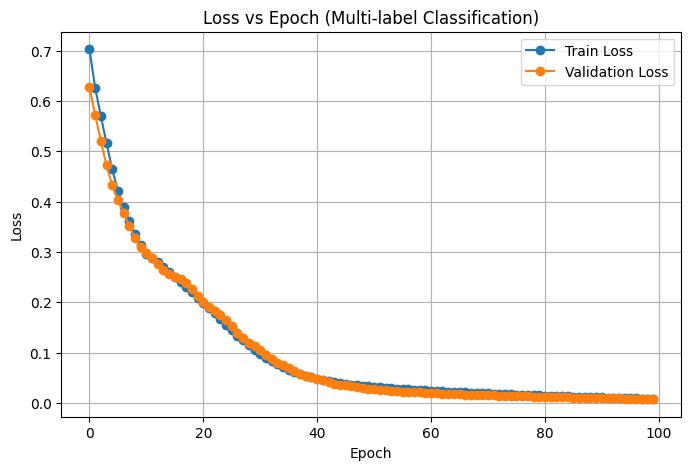

Test lateral embeddings shape for multi-label classifier: torch.Size([70, 384])
Test tissue labels shape for multi-label classifier: torch.Size([70, 5])
Test Loss (Multi-label): 0.0647, Test Accuracy (Multi-label): 0.9657


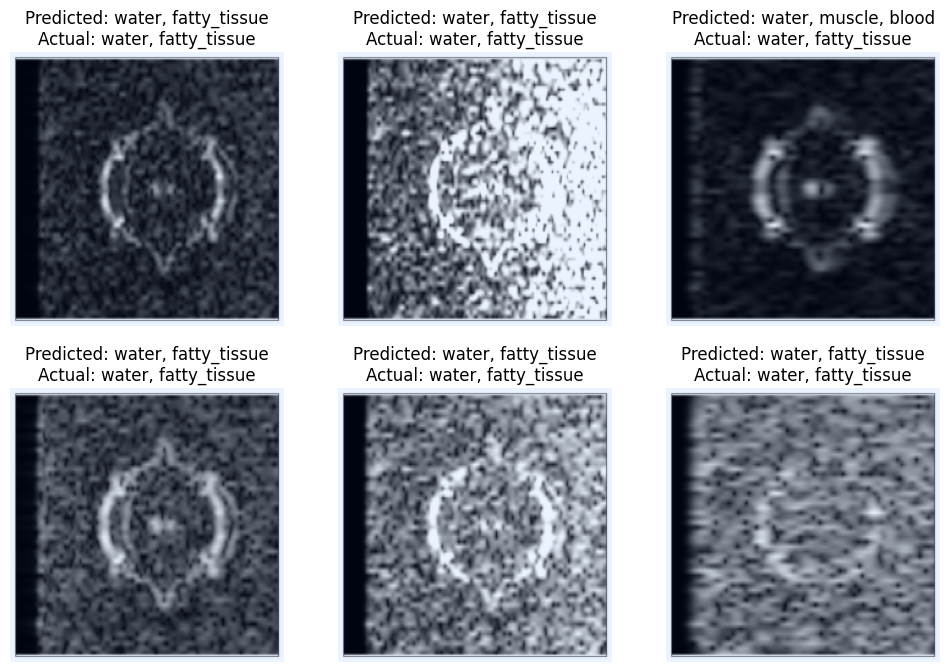

In [75]:
# Cell 12: Define a multi-label MLP classifier for the tissue types with two hidden layers
class MultiLabelMLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MultiLabelMLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Use sigmoid for multi-label classification
        return x
    
# Initialize the multi-label classifier and define loss and optimizer
input_dim = train_lateral_embeddings.shape[-1]  # emb_dim
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = 5  # 5 tissue types
multi_label_classifier = MultiLabelMLPClassifier(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)
# Ensure the classifier is on the same device as the embeddings
multi_label_classifier.to(device)
# Print the classifier architecture
print(multi_label_classifier)

# Define loss function and optimizer for multi-label classification
criterion_multi_label = nn.BCELoss()  # Binary Cross Entropy Loss for multi-label classification
optimizer_multi_label = torch.optim.Adam(multi_label_classifier.parameters(), lr=0.001)

def train_multi_label_classifier(classifier, train_embeddings, train_labels, val_embeddings, val_labels, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        classifier.train()
        optimizer.zero_grad()
        outputs = classifier(train_embeddings)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        classifier.eval()
        with torch.no_grad():
            val_outputs = classifier(val_embeddings)
            val_loss = criterion(val_outputs, val_labels)
            val_losses.append(val_loss.item())
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    return train_losses, val_losses

# Average the embeddings across all patches for each image in the train and val sets
avg_train_lateral_embeddings = train_lateral_embeddings.mean(dim=1)  # [N, emb_dim]
avg_val_lateral_embeddings = val_lateral_embeddings.mean(dim=1)  # [N, emb_dim]
# Convert to float32 for compatibility with the classifier
avg_train_lateral_embeddings = avg_train_lateral_embeddings.float()
avg_val_lateral_embeddings = avg_val_lateral_embeddings.float()
# Print shapes to verify
print(f"Train lateral embeddings shape for multi-label classifier: {avg_train_lateral_embeddings.shape}")  # [N, emb_dim]
print(f"Val lateral embeddings shape for multi-label classifier: {avg_val_lateral_embeddings.shape}")      # [N, emb_dim]
# Convert labels to float32 for compatibility with the classifier
train_tissue_labels = train_tissue_labels.float()
val_tissue_labels = val_tissue_labels.float()
# Print shapes to verify
print(f"Train tissue labels shape for multi-label classifier: {train_tissue_labels.shape}")  # [N, 5]
print(f"Val tissue labels shape for multi-label classifier: {val_tissue_labels.shape}")      # [N, 5]

# Train the multi-label classifier on the train set and validate on the val set
train_losses_multi, val_losses_multi = train_multi_label_classifier(
    multi_label_classifier,
    avg_train_lateral_embeddings.to(device),
    train_tissue_labels.to(device),
    avg_val_lateral_embeddings.to(device),
    val_tissue_labels.to(device),
    criterion_multi_label,
    optimizer_multi_label,
    num_epochs=100
)
# Plot loss vs epoch for multi-label classification
plt.figure(figsize=(8, 5))
plt.plot(train_losses_multi, 'o-', label='Train Loss')
plt.plot(val_losses_multi, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch (Multi-label Classification)')
plt.legend()
plt.grid(True)
plt.show()

# Test the multi-label MLP decoder on the test set and evaluate its performance
def evaluate_multi_label_classifier(classifier, test_embeddings, test_labels, criterion
):
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(test_embeddings)
        loss = criterion(outputs, test_labels)
        predictions = (outputs > 0.5).float()  # Threshold at 0.5 for multi-label classification
        accuracy = (predictions == test_labels).float().mean().item()
    return loss.item(), accuracy

# Average the embeddings across all patches for each image in the test set
avg_test_lateral_embeddings = test_lateral_embeddings.mean(dim=1)  # [N, emb_dim]
# Convert to float32 for compatibility with the classifier
avg_test_lateral_embeddings = avg_test_lateral_embeddings.float()
# Print shape to verify
print(f"Test lateral embeddings shape for multi-label classifier: {avg_test_lateral_embeddings.shape}")  # [N, emb_dim]
# Convert labels to float32 for compatibility with the classifier
test_tissue_labels = test_tissue_labels.float()
# Print shape to verify
print(f"Test tissue labels shape for multi-label classifier: {test_tissue_labels.shape}")  # [N, 5]

# Evaluate the multi-label classifier on the test set
test_loss_multi, test_accuracy_multi = evaluate_multi_label_classifier(
    multi_label_classifier,
    avg_test_lateral_embeddings.to(device),
    test_tissue_labels.to(device),
    criterion_multi_label
)
print(f"Test Loss (Multi-label): {test_loss_multi:.4f}, Test Accuracy (Multi-label): {test_accuracy_multi:.4f}")

# Test the multi-label classifier on 6 random images from the test set
random_indices = random.sample(range(test_images_tensor.shape[0]), 6)
# Get the corresponding images, their names, labels, and embeddings
test_images_sample_multi = test_images_tensor[random_indices]
test_images_names_sample_multi = [os.path.basename(test_images[i]) for i in random_indices]
test_embeddings_sample_multi = avg_test_lateral_embeddings[random_indices]
test_tissue_labels_sample_multi = test_tissue_labels[random_indices]
# use tissue_to_index to convert the tissue labels to a list of strings
test_word_tissue_labels_sample_multi = [
    [unique_tissues[i] for i in range(len(unique_tissues)) if label[i] == 1.0]
    for label in test_tissue_labels_sample_multi.cpu().numpy()
]
# get the predicted labels for these images
with torch.no_grad():
    predicted_labels_multi = multi_label_classifier(test_embeddings_sample_multi.to(device)).squeeze().cpu().numpy()
predicted_word_tissue_labels_multi = [
    [unique_tissues[i] for i in range(len(unique_tissues)) if label[i] > 0.5]
    for label in predicted_labels_multi
]
# prepare a figure showing the images and their predicted labels
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    img = test_images_tensor[idx].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {', '.join(predicted_word_tissue_labels_multi[i])}\nActual: {', '.join(test_word_tissue_labels_sample_multi[i])}")
    plt.axis('off')


# Use predictor embeddings for binary classification

MLPClassifier(
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)
Train predictor embeddings shape for classifier: torch.Size([1006, 384])
Val predictor embeddings shape for classifier: torch.Size([215, 384])
Train labels shape for classifier: torch.Size([1006])
Val labels shape for classifier: torch.Size([215])
Epoch [1/100], Loss: 0.6820, Val Loss: 0.6406
Epoch [2/100], Loss: 0.6082, Val Loss: 0.6149
Epoch [3/100], Loss: 0.5777, Val Loss: 0.5770
Epoch [4/100], Loss: 0.5458, Val Loss: 0.5457
Epoch [5/100], Loss: 0.5238, Val Loss: 0.5267
Epoch [6/100], Loss: 0.5116, Val Loss: 0.5147
Epoch [7/100], Loss: 0.5019, Val Loss: 0.5076
Epoch [8/100], Loss: 0.4932, Val Loss: 0.5024
Epoch [9/100], Loss: 0.4845, Val Loss: 0.4985
Epoch [10/100], Loss: 0.4759, Val Loss: 0.4933
Epoch [11/100], Loss: 0.4669, Val Loss: 0.4849
Epoch [12/100], Loss: 0.4564, Val Loss: 0.4

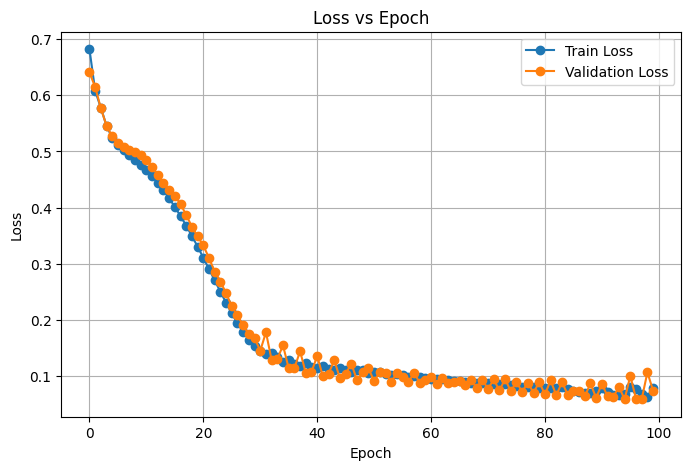

Test predictor embeddings shape for classifier: torch.Size([70, 384])
Test labels shape for classifier: torch.Size([70])
Test Loss: 0.2966, Test Accuracy: 0.9429


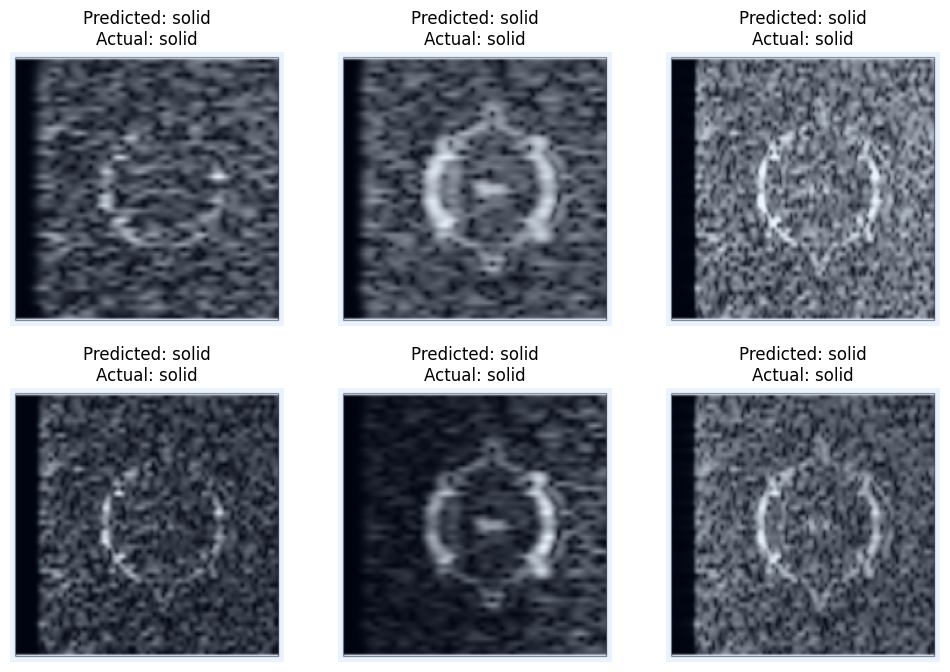

In [76]:
# Cell 13: Use predictor embeddings for the binary classification task (solid vs hollow)    

# Initialize the classifier and define loss and optimizer
# Initialize the classifier
input_dim = train_predictor_embeddings.shape[-1]  # emb_dim
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = 1  # Binary classification (solid vs hollow)
classifier = MLPClassifier(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)
# Ensure the classifier is on the same device as the embeddings
classifier.to(device)
# Print the classifier architecture
print(classifier)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# Each patch has an embedding of size emb_dim, so we need to average the embeddings across all patches for each image
avg_train_predictor_embeddings = train_predictor_embeddings.mean(dim=1)  # [N, emb_dim]
avg_val_predictor_embeddings = val_predictor_embeddings.mean(dim=1)  # [N, emb_dim]
# Convert to float32 for compatibility with the classifier
avg_train_predictor_embeddings = avg_train_predictor_embeddings.float()
avg_val_predictor_embeddings = avg_val_predictor_embeddings.float()
# Print shapes to verify
print(f"Train predictor embeddings shape for classifier: {avg_train_predictor_embeddings.shape}")  # [N, emb_dim]
print(f"Val predictor embeddings shape for classifier: {avg_val_predictor_embeddings.shape}")      # [N, emb_dim]
# Convert labels to float32 for compatibility with the classifier
train_labels = train_labels.float()
val_labels = val_labels.float()
# Print shapes to verify
print(f"Train labels shape for classifier: {train_labels.shape}")  # [N]
print(f"Val labels shape for classifier: {val_labels.shape}")      # [N]

# Train the classifier on the train set and validate on the val set
train_losses, val_losses = train_classifier(
    classifier,
    avg_train_predictor_embeddings.to(device),
    train_labels.to(device),
    avg_val_predictor_embeddings.to(device),
    val_labels.to(device),
    criterion,
    optimizer,
    num_epochs=100
)

# Plot loss vs epoch
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, 'o-', label='Train Loss')
plt.plot(val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Test the MLP decoder on the test set and evaluate its performance
def evaluate_classifier(classifier, test_embeddings, test_labels, criterion):
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(test_embeddings)
        loss = criterion(outputs.squeeze(), test_labels)
        predictions = (outputs.squeeze() > 0.5).float()  # Threshold at 0.5 for binary classification
        accuracy = (predictions == test_labels).float().mean().item()
    return loss.item(), accuracy

# Average the embeddings across all patches for each image in the test set
avg_test_predictor_embeddings = test_predictor_embeddings.mean(dim=1)  # [N, emb_dim]
# Convert to float32 for compatibility with the classifier
avg_test_predictor_embeddings = avg_test_predictor_embeddings.float()
# Print shape to verify
print(f"Test predictor embeddings shape for classifier: {avg_test_predictor_embeddings.shape}")  # [N, emb_dim]
# Convert labels to float32 for compatibility with the classifier
test_labels = test_labels.float()
# Print shape to verify
print(f"Test labels shape for classifier: {test_labels.shape}")  # [N]

# Evaluate the classifier on the test set
test_loss, test_accuracy = evaluate_classifier(
    classifier,
    avg_test_predictor_embeddings.to(device),
    test_labels.to(device),
    criterion
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Test the classifier on 6 random images from the test set
import random
# get 6 random indices from the test set
random_indices = random.sample(range(test_images_tensor.shape[0]), 6)
# Get the corresponding images, their names, labels, and embeddings
test_images_sample = test_images_tensor[random_indices]
test_images_names_sample = [os.path.basename(test_images[i]) for i in random_indices]
test_embeddings_sample = avg_test_predictor_embeddings[random_indices]
test_labels_sample = test_labels[random_indices]
test_word_labels_sample = ['solid' if label == 1 else 'hollow' for label in test_labels_sample.cpu().numpy()]
# get the predicted labels for these images
with torch.no_grad():
    predicted_labels = classifier(test_embeddings_sample.to(device)).squeeze().cpu().numpy()
# convert predicted labels to a word. 1 means 'solid', 0 means 'hollow'
predicted_word_labels = ['solid' if label > 0.5 else 'hollow' for label in predicted_labels]
# prepare a figure showing the images and their predicted labels
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    img = test_images_tensor[idx].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_word_labels[i]}\nActual: {test_word_labels_sample[i]}")
    plt.axis('off')

# Using predictor embeddings for tissue type classification

MultiLabelMLPClassifier(
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
)
Train predictor embeddings shape for multi-label classifier: torch.Size([1006, 384])
Val predictor embeddings shape for multi-label classifier: torch.Size([215, 384])
Train tissue labels shape for multi-label classifier: torch.Size([1006, 5])
Val tissue labels shape for multi-label classifier: torch.Size([215, 5])
Epoch [1/100], Loss: 0.6878, Val Loss: 0.5990
Epoch [2/100], Loss: 0.5971, Val Loss: 0.5329
Epoch [3/100], Loss: 0.5282, Val Loss: 0.4798
Epoch [4/100], Loss: 0.4713, Val Loss: 0.4432
Epoch [5/100], Loss: 0.4300, Val Loss: 0.4174
Epoch [6/100], Loss: 0.4000, Val Loss: 0.3932
Epoch [7/100], Loss: 0.3733, Val Loss: 0.3680
Epoch [8/100], Loss: 0.3481, Val Loss: 0.3446
Epoch [9/100], Loss: 0.3270, Val Loss: 0.3260
Epoch [10/100], Loss: 0.3124, Val Loss: 0.3126
Epoch [11/10

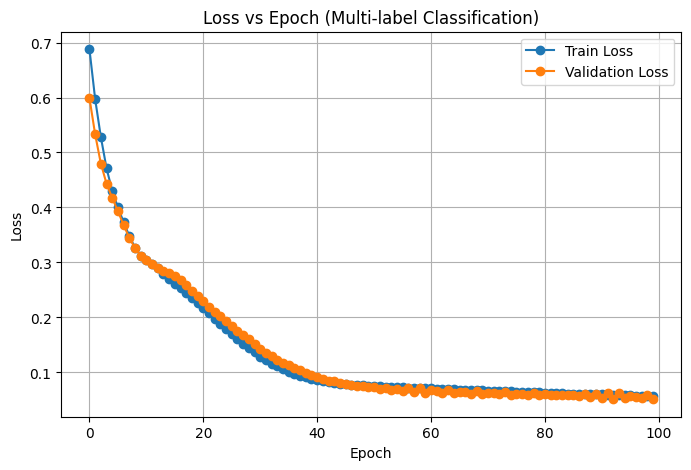

Test predictor embeddings shape for multi-label classifier: torch.Size([70, 384])
Test tissue labels shape for multi-label classifier: torch.Size([70, 5])
Test Loss (Multi-label): 0.1386, Test Accuracy (Multi-label): 0.9657


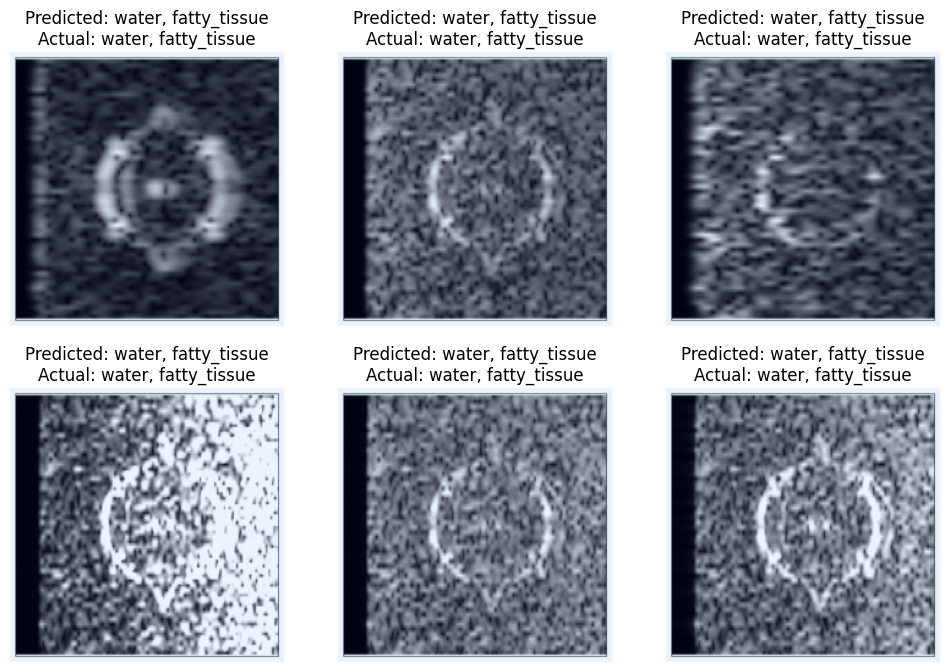

In [77]:
# Cell 14: Using predictor embeddings for the multi-label classification task (tissue types)

# Initialize the multi-label classifier and define loss and optimizer
input_dim = train_predictor_embeddings.shape[-1]  # emb_dim
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = 5  # 5 tissue types
multi_label_classifier = MultiLabelMLPClassifier(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)
# Ensure the classifier is on the same device as the embeddings
multi_label_classifier.to(device)
# Print the classifier architecture
print(multi_label_classifier)

# Define loss function and optimizer for multi-label classification
criterion_multi_label = nn.BCELoss()  # Binary Cross Entropy Loss for multi-label classification
optimizer_multi_label = torch.optim.Adam(multi_label_classifier.parameters(), lr=0.001)

# Average the embeddings across all patches for each image in the train and val sets
avg_train_predictor_embeddings = train_predictor_embeddings.mean(dim=1)  # [N, emb_dim]
avg_val_predictor_embeddings = val_predictor_embeddings.mean(dim=1)  # [N, emb_dim]
# Convert to float32 for compatibility with the classifier
avg_train_predictor_embeddings = avg_train_predictor_embeddings.float()
avg_val_predictor_embeddings = avg_val_predictor_embeddings.float()
# Print shapes to verify
print(f"Train predictor embeddings shape for multi-label classifier: {avg_train_predictor_embeddings.shape}")  # [N, emb_dim]
print(f"Val predictor embeddings shape for multi-label classifier: {avg_val_predictor_embeddings.shape}")      # [N, emb_dim]
# Convert labels to float32 for compatibility with the classifier
train_tissue_labels = train_tissue_labels.float()
val_tissue_labels = val_tissue_labels.float()
# Print shapes to verify
print(f"Train tissue labels shape for multi-label classifier: {train_tissue_labels.shape}")  # [N, 5]
print(f"Val tissue labels shape for multi-label classifier: {val_tissue_labels.shape}")      # [N, 5]

# Train the multi-label classifier on the train set and validate on the val set
train_losses_multi, val_losses_multi = train_multi_label_classifier(
    multi_label_classifier,
    avg_train_predictor_embeddings.to(device),
    train_tissue_labels.to(device),
    avg_val_predictor_embeddings.to(device),
    val_tissue_labels.to(device),
    criterion_multi_label,
    optimizer_multi_label,
    num_epochs=100
)
# Plot loss vs epoch for multi-label classification
plt.figure(figsize=(8, 5))
plt.plot(train_losses_multi, 'o-', label='Train Loss')
plt.plot(val_losses_multi, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch (Multi-label Classification)')
plt.legend()
plt.grid(True)
plt.show()

# Test the multi-label MLP decoder on the test set and evaluate its performance
def evaluate_multi_label_classifier(classifier, test_embeddings, test_labels, criterion
):
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(test_embeddings)
        loss = criterion(outputs, test_labels)
        predictions = (outputs > 0.5).float()  # Threshold at 0.5 for multi-label classification
        accuracy = (predictions == test_labels).float().mean().item()
    return loss.item(), accuracy

# Average the embeddings across all patches for each image in the test set
avg_test_predictor_embeddings = test_predictor_embeddings.mean(dim=1)  # [N, emb_dim]
# Convert to float32 for compatibility with the classifier
avg_test_predictor_embeddings = avg_test_predictor_embeddings.float()
# Print shape to verify
print(f"Test predictor embeddings shape for multi-label classifier: {avg_test_predictor_embeddings.shape}")  # [N, emb_dim]
# Convert labels to float32 for compatibility with the classifier
test_tissue_labels = test_tissue_labels.float()
# Print shape to verify
print(f"Test tissue labels shape for multi-label classifier: {test_tissue_labels.shape}")  # [N, 5]

# Evaluate the multi-label classifier on the test set
test_loss_multi, test_accuracy_multi = evaluate_multi_label_classifier(
    multi_label_classifier,
    avg_test_predictor_embeddings.to(device),
    test_tissue_labels.to(device),
    criterion_multi_label
)
print(f"Test Loss (Multi-label): {test_loss_multi:.4f}, Test Accuracy (Multi-label): {test_accuracy_multi:.4f}")

# Test the multi-label classifier on 6 random images from the test set
random_indices = random.sample(range(test_images_tensor.shape[0]), 6)
# Get the corresponding images, their names, labels, and embeddings
test_images_sample_multi = test_images_tensor[random_indices]
test_images_names_sample_multi = [os.path.basename(test_images[i]) for i in random_indices]
test_embeddings_sample_multi = avg_test_predictor_embeddings[random_indices]
test_tissue_labels_sample_multi = test_tissue_labels[random_indices]
# use tissue_to_index to convert the tissue labels to a list of strings
test_word_tissue_labels_sample_multi = [
    [unique_tissues[i] for i in range(len(unique_tissues)) if label[i] == 1.0]
    for label in test_tissue_labels_sample_multi.cpu().numpy()
]
# get the predicted labels for these images
with torch.no_grad():
    predicted_labels_multi = multi_label_classifier(test_embeddings_sample_multi.to(device)).squeeze().cpu().numpy()
predicted_word_tissue_labels_multi = [
    [unique_tissues[i] for i in range(len(unique_tissues)) if label[i] > 0.5]
    for label in predicted_labels_multi
]
# prepare a figure showing the images and their predicted labels
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    img = test_images_tensor[idx].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {', '.join(predicted_word_tissue_labels_multi[i])}\nActual: {', '.join(test_word_tissue_labels_sample_multi[i])}")
    plt.axis('off')
